In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

#image
from skimage.transform import resize
from skimage.util import crop
import random
import numpy as np

#keras
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Activation, Add, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Conv2D, ReLU, LeakyReLU, Conv2DTranspose, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

#pip install -q -U tensorboard

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
#Hyperparameters
PATH = ".//Data/Images/"
nofinding_path = "./nofinding_pa_labels.csv"
effusion_path = "./effusion_pa_labels.csv"
infiltration_path = "./infiltration_pa_labels.csv"

BUFFER_SIZE = 400
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

N_CLASSES = 3
CLASS_NAMES = [ 'Effusion', 'Infiltration', 'NoFinding']

OUTPUT_CHANNELS = 3
EPOCHS =150

In [7]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image, channels=3)
    
    input_image = tf.cast(image, tf.float32)
    input_image = input_image / 255.
    
    return input_image

(1024, 1024, 3)


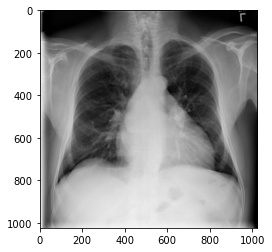

In [8]:
#test_load_image
inp= load(PATH+'00000001_000.png')
# casting to int for matplotlib to show the image
print(inp.shape)
plt.figure()
plt.imshow(inp)

In [9]:
#Preprocessing
def resize(input_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return input_image

def random_crop(input_image):

    cropped_image = tf.image.random_crop(input_image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

def normalize(input_image):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    input_image = (input_image - imagenet_mean) / imagenet_std
    return input_image


@tf.function()
def random_jitter(input_image):
    input_image = resize(input_image, 254, 254) # resizing to 286 x 286 x 3

    input_image = random_crop(input_image) # randomly cropping to 256 x 256 x 3

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)

    return input_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


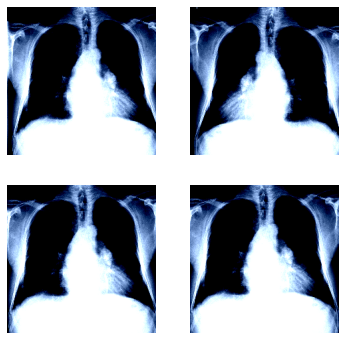

In [10]:
#test_jitter
"""
1. Resize an image to bigger height and width
2. Randomly crop to the target size
3. Randomly flip the image horizontally
"""

plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp = random_jitter(inp)
    rj_inp = normalize(rj_inp)
    out2 = rj_inp
    plt.subplot(2, 2, i+1)
    plt.imshow(out2)
    plt.axis('off')
plt.show()

In [11]:
def load_image_train(image_file):
    input_image = load(PATH+image_file)
    input_image = random_jitter(input_image)
    input_image = normalize(input_image)

    return input_image

def load_image_test(image_file):
    input_image = load(PATH+image_file)
    input_image = resize(input_image, IMG_HEIGHT, IMG_WIDTH)
    input_image = normalize(input_image)

    return input_image

In [12]:
def load_csv_train(image, label):
    input_image = load_image_train(image)

    return input_image, label

def load_csv_test(image, label):
    input_image = load_image_test(image)

    return input_image, label

#Input Pipeline
import pandas as pd
import numpy

num_lines_eff = sum(1 for l in open(effusion_path))
num_lines_inf = sum(1 for l in open(infiltration_path))
num_lines_no = sum(1 for l in open(nofinding_path))
print(num_lines_eff)
print(num_lines_inf)
print(num_lines_no)

size_train = 2000
size_test = 200

skip_idx_train_eff = random.sample(range(1, num_lines_eff), num_lines_eff - size_train)
skip_idx_test_eff = random.sample(range(1, num_lines_eff), num_lines_eff - size_test)
skip_idx_train_inf = random.sample(range(1, num_lines_inf), num_lines_inf - size_train)
skip_idx_test_inf = random.sample(range(1, num_lines_inf), num_lines_inf - size_test)
skip_idx_train_no = random.sample(range(1, num_lines_no), num_lines_no - size_train)
skip_idx_test_no = random.sample(range(1, num_lines_no), num_lines_no - size_test)

eff_train = pd.read_csv(effusion_path, skiprows=skip_idx_train_eff, index_col=None, header = 0)
eff_test = pd.read_csv(effusion_path, skiprows=skip_idx_test_eff, index_col=None, header = 0)
inf_train = pd.read_csv(infiltration_path,  skiprows=skip_idx_train_inf, index_col=None, header = 0)
inf_test = pd.read_csv(infiltration_path,  skiprows=skip_idx_test_inf, index_col=None, header = 0)
no_train = pd.read_csv(nofinding_path,  skiprows=skip_idx_train_no, index_col=None, header = 0)
no_test = pd.read_csv(nofinding_path,  skiprows=skip_idx_test_no, index_col=None, header = 0)

train = []
train.append(eff_train)
train.append(inf_train)
train.append(no_train)
train = pd.concat(train, axis=0, ignore_index=True)
from sklearn.utils import shuffle
train = shuffle(train)
image_train = train.pop('Image Index')
label_train = train.pop('Finding Labels')
print(image_train)
print(label_train)

train_dataset = tf.data.Dataset.from_tensor_slices((image_train, label_train))
train_dataset = train_dataset.map(load_csv_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test = []
test.append(eff_test)
test.append(inf_test)
test.append(no_test)
test = pd.concat(test, axis=0, ignore_index=True)
from sklearn.utils import shuffle
test = shuffle(test)
image_test = test.pop('Image Index')
label_test = test.pop('Finding Labels')
print(image_test)
print(label_test)

test_dataset = tf.data.Dataset.from_tensor_slices((image_test, label_test))
test_dataset = test_dataset.map(load_csv_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

2087
5271
39303
3131    00009336_019.png
2662    00004353_000.png
2483    00002869_000.png
5105    00000765_005.png
3116    00009196_000.png
              ...       
977     00012804_011.png
2636    00004027_000.png
2677    00004508_003.png
5721    00001183_001.png
783     00010863_004.png
Name: Image Index, Length: 5997, dtype: object
3131    1
2662    1
2483    1
5105    2
3116    1
       ..
977     0
2636    1
2677    1
5721    2
783     0
Name: Finding Labels, Length: 5997, dtype: int64
133    00002120_005.png
68     00000927_004.png
239    00000246_017.png
135    00002248_004.png
192    00003083_001.png
             ...       
259    00000370_010.png
231    00000213_002.png
305    00000620_000.png
589    00000172_001.png
96     00001437_012.png
Name: Image Index, Length: 597, dtype: object
133    0
68     0
239    1
135    0
192    0
      ..
259    1
231    1
305    1
589    2
96     0
Name: Finding Labels, Length: 597, dtype: int64


In [55]:
#Build Model
def CNN_MODEL():
    inputs = Input(shape=[IMG_HEIGHT, IMG_WIDTH,3])
    
    x= inputs
    
    initializer = tf.random_normal_initializer(0., 0.02)

    model = Sequential()
    model.add(Conv2D(64, 4, strides=2, padding='valid', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, 4, strides=2, padding='valid',
                                 kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, 4, strides=2, padding='valid',
                                 kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3))
    
    x=model(x)
    
    return Model(inputs=inputs, outputs = x)

In [5]:
#model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 111, 111, 64)      3136      
_________________________________________________________________
batch_normalization_3 (Batch (None, 111, 111, 64)      256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 111, 111, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 128)       131200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 26, 128)       512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 26, 26, 128)      

In [56]:
CNN = CNN_MODEL()
CNN.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 3)                 931395    
Total params: 931,395
Trainable params: 930,499
Non-trainable params: 896
_________________________________________________________________


In [57]:
checkpoint_path = "./CNN_Train_Models/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch',
    period = 10)

CNN.save_weights(checkpoint_path.format(epoch=0))

optimizer = Adam(lr=0.001)
CNN.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
history = CNN.fit(train_dataset, epochs=250, 
                    validation_data=(test_dataset),
                    callbacks=[cp_callback])


Epoch 1/250
188/188 [==============================] - 57s 303ms/step - loss: 1.0737 - accuracy: 0.4466 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/250
188/188 [==============================] - 49s 259ms/step - loss: 1.0274 - accuracy: 0.4726 - val_loss: 1.1337 - val_accuracy: 0.3451
Epoch 3/250
188/188 [==============================] - 50s 266ms/step - loss: 1.0122 - accuracy: 0.4801 - val_loss: 1.0533 - val_accuracy: 0.4690
Epoch 4/250
188/188 [==============================] - 50s 264ms/step - loss: 1.0008 - accuracy: 0.4901 - val_loss: 1.1008 - val_accuracy: 0.4405
Epoch 5/250
188/188 [==============================] - 49s 260ms/step - loss: 0.9937 - accuracy: 0.4987 - val_loss: 1.0191 - val_accuracy: 0.5126
Epoch 6/250
188/188 [==============================] - 49s 260ms/step - loss: 0.9917 - accuracy: 0.5131 - val_loss: 1.0600 - val_accuracy: 0.4439
Epoch 7/250
188/188 [==============================] - 49s 260ms/step - loss: 0.9853 - accuracy: 0.5029 - val_loss: 

Epoch 51/250
188/188 [==============================] - 49s 260ms/step - loss: 0.8206 - accuracy: 0.6203 - val_loss: 0.8655 - val_accuracy: 0.5963
Epoch 52/250
188/188 [==============================] - 49s 260ms/step - loss: 0.8251 - accuracy: 0.6031 - val_loss: 0.8519 - val_accuracy: 0.5846
Epoch 53/250
188/188 [==============================] - 50s 268ms/step - loss: 0.8185 - accuracy: 0.6171 - val_loss: 0.8651 - val_accuracy: 0.5762
Epoch 54/250
188/188 [==============================] - 49s 262ms/step - loss: 0.8137 - accuracy: 0.6171 - val_loss: 0.8321 - val_accuracy: 0.5963
Epoch 55/250
188/188 [==============================] - 49s 259ms/step - loss: 0.8116 - accuracy: 0.6215 - val_loss: 0.8864 - val_accuracy: 0.5544
Epoch 56/250
188/188 [==============================] - 49s 260ms/step - loss: 0.8068 - accuracy: 0.6216 - val_loss: 0.8674 - val_accuracy: 0.5578
Epoch 57/250
188/188 [==============================] - 49s 260ms/step - loss: 0.8084 - accuracy: 0.6273 - val_loss: 0

Epoch 102/250
188/188 [==============================] - 49s 262ms/step - loss: 0.6870 - accuracy: 0.6933 - val_loss: 0.7636 - val_accuracy: 0.6499
Epoch 103/250
188/188 [==============================] - 49s 260ms/step - loss: 0.6817 - accuracy: 0.6982 - val_loss: 0.7345 - val_accuracy: 0.6482
Epoch 104/250
188/188 [==============================] - 49s 260ms/step - loss: 0.6765 - accuracy: 0.7015 - val_loss: 0.7980 - val_accuracy: 0.6281
Epoch 105/250
188/188 [==============================] - 51s 271ms/step - loss: 0.6802 - accuracy: 0.6990 - val_loss: 0.7642 - val_accuracy: 0.6482
Epoch 106/250
188/188 [==============================] - 50s 264ms/step - loss: 0.6795 - accuracy: 0.6872 - val_loss: 0.7260 - val_accuracy: 0.6750
Epoch 107/250
188/188 [==============================] - 50s 268ms/step - loss: 0.6733 - accuracy: 0.7059 - val_loss: 0.7406 - val_accuracy: 0.6616
Epoch 108/250
188/188 [==============================] - 49s 261ms/step - loss: 0.6672 - accuracy: 0.6987 - val_

188/188 [==============================] - 49s 259ms/step - loss: 0.4557 - accuracy: 0.8066 - val_loss: 0.7935 - val_accuracy: 0.6868
Epoch 203/250
188/188 [==============================] - 49s 258ms/step - loss: 0.4567 - accuracy: 0.8056 - val_loss: 0.8215 - val_accuracy: 0.6784
Epoch 204/250
188/188 [==============================] - 49s 263ms/step - loss: 0.4541 - accuracy: 0.8156 - val_loss: 0.7590 - val_accuracy: 0.7035
Epoch 205/250
188/188 [==============================] - 49s 258ms/step - loss: 0.4524 - accuracy: 0.8064 - val_loss: 0.8533 - val_accuracy: 0.6817
Epoch 206/250
188/188 [==============================] - 49s 260ms/step - loss: 0.4388 - accuracy: 0.8127 - val_loss: 0.8125 - val_accuracy: 0.6935
Epoch 207/250
188/188 [==============================] - 49s 258ms/step - loss: 0.4503 - accuracy: 0.8107 - val_loss: 0.7606 - val_accuracy: 0.6884
Epoch 208/250
188/188 [==============================] - 49s 259ms/step - loss: 0.4540 - accuracy: 0.8057 - val_loss: 0.9005 -

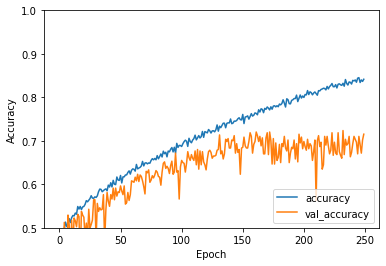

In [58]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [132]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

model = CNN_MODEL()
model.load_weights(latest)

tp_eff = 0
tn_eff = 0
fp_eff = 0
fn_eff = 0
tp_inf = 0
tn_inf = 0
fp_inf = 0
fn_inf = 0
tp_no = 0
tn_no = 0
fp_no = 0
fn_no = 0
for image, label in test_dataset:
    out = model(image)
    predicted = tf.argmax(out, axis=1)
    
    if(label == 0):
        if(predicted == 0):
            tp_eff +=1
            tn_inf +=1
            tn_no +=1
        elif(predicted == 1):
            fp_eff +=1
            fn_inf +=1
            tn_no +=1
        else:
            fp_eff +=1
            tn_inf +=1
            fn_no +=1
    elif(label == 1):
        if(predicted == 0):
            fn_eff +=1
            fp_inf +=1
            tn_no +=1
        elif(predicted == 1):
            tn_eff +=1
            tp_inf +=1
            tn_no +=1
        else:
            tn_eff +=1
            fp_inf +=1
            fn_no +=1
    else:
        if(predicted == 0):
            fn_eff +=1
            tn_inf +=1
            fp_no +=1
        elif(predicted == 1):
            tn_eff +=1
            fn_inf +=1
            fp_no +=1
        else:
            tn_eff +=1
            tn_inf +=1
            tp_no +=1

print()
print('tp_eff: ', tp_eff)
print('tn_eff: ', tn_eff)
print('fp_eff: ', fp_eff)
print('fn_eff: ', fn_eff)
print()
print('tp_inf: ', tp_inf)
print('tn_inf: ', tn_inf)
print('fp_inf: ', fp_inf)
print('fn_inf: ', fn_inf)
print()
print('tp_no: ', tp_no)
print('tn_no: ', tn_no)
print('fp_no: ', fp_no)
print('fn_no: ', fn_no)


tp_eff:  160
tn_eff:  369
fp_eff:  39
fn_eff:  29

tp_inf:  108
tn_inf:  365
fp_inf:  91
fn_inf:  33

tp_no:  167
tn_no:  298
fp_no:  32
fn_no:  100


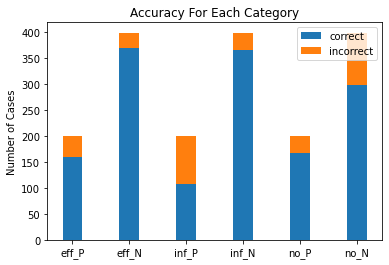

<Figure size 432x288 with 0 Axes>

Effusion Sensitivity     / True Positive Rate:  0.8465608465608465
Infiltration Sensitivity / True Positive Rate:  0.7659574468085106
No Finding Sensitivity   / True Positive Rate:  0.6254681647940075

Effusion Specificity     / True Negative Rate:  0.9044117647058824
Infiltration Specificity / True Negative Rate:  0.8004385964912281
No Finding Specificity   / True Negative Rate:  0.9030303030303031


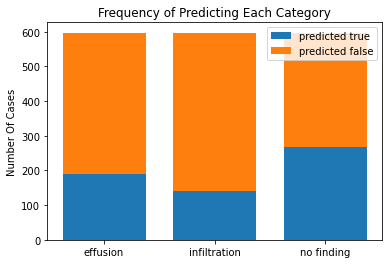

<Figure size 432x288 with 0 Axes>

In [130]:
labels = ['eff_P', 'eff_N', 'inf_P', 'inf_N', 'no_P','no_N']
tru = [tp_eff, tn_eff, tp_inf, tn_inf, tp_no, tn_no]
fal = [fp_eff, fn_eff, fp_inf, fn_inf, fp_no, fn_no]

width = 0.35

fig, ax = plt.subplots()

ax.bar(labels, tru, width, label='correct')
ax.bar(labels, fal, width, bottom=tru,
       label='incorrect')

ax.set_ylabel('Number of Cases')
ax.set_title('Accuracy For Each Category')
ax.legend()

plt.figure()
plt.show()

print('Effusion Sensitivity     / True Positive Rate: ', tp_eff/(tp_eff+fn_eff))
print('Infiltration Sensitivity / True Positive Rate: ', tp_inf/(tp_inf+fn_inf))
print('No Finding Sensitivity   / True Positive Rate: ', tp_no/(tp_no+fn_no))
print()
print('Effusion Specificity     / True Negative Rate: ', tn_eff/(tn_eff+fp_eff))
print('Infiltration Specificity / True Negative Rate: ', tn_inf/(tn_inf+fp_inf))
print('No Finding Specificity   / True Negative Rate: ', tn_no/(tn_no+fp_no))

labels = ['effusion', 'infiltration', 'no finding']
tru = [tp_eff+fn_eff, tp_inf+fn_inf, tp_no+fn_no]
fal = [fp_eff+tn_eff, fp_inf+tn_inf, fp_no+tn_no]

width = 0.75

fig, ax = plt.subplots()

ax.bar(labels, tru, width, label='predicted true')
ax.bar(labels, fal, width, bottom=tru,
       label='predicted false')

ax.set_ylabel('Number Of Cases')
ax.set_title('Frequency of Predicting Each Category')
ax.legend()

plt.figure()
plt.show()


In [21]:
import keras

def DenseNet_MODEL():
    img_input = Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    
    base_model = tf.keras.applications.densenet.DenseNet121(
        include_top=False,
        input_tensor=img_input,
        input_shape=[IMG_HEIGHT, IMG_WIDTH, 3],
        weights="imagenet",
        pooling="avg")
    
    x = base_model.output
    predictions = Dense(3, name="predictions")(x)
    return Model(inputs=img_input, outputs=predictions)

Using TensorFlow backend.


In [27]:
checkpoint_path = "./DenseNet_Train_Models/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch',
    period = 10)

model = DenseNet_MODEL()

model.save_weights(checkpoint_path.format(epoch=0))

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
history = model.fit(train_dataset, epochs=EPOCHS, 
                    validation_data=(test_dataset),
                    callbacks=[cp_callback])

Epoch 1/150
188/188 [==============================] - 118s 627ms/step - loss: 0.9592 - accuracy: 0.5246 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/150
188/188 [==============================] - 92s 492ms/step - loss: 0.8836 - accuracy: 0.5658 - val_loss: 9.7072 - val_accuracy: 0.3920
Epoch 3/150
188/188 [==============================] - 92s 489ms/step - loss: 0.8677 - accuracy: 0.5693 - val_loss: 1.0695 - val_accuracy: 0.4941
Epoch 4/150
188/188 [==============================] - 94s 498ms/step - loss: 0.8547 - accuracy: 0.5765 - val_loss: 1.3583 - val_accuracy: 0.5327
Epoch 5/150
188/188 [==============================] - 92s 487ms/step - loss: 0.8429 - accuracy: 0.5771 - val_loss: 2.3887 - val_accuracy: 0.5595
Epoch 6/150
188/188 [==============================] - 91s 484ms/step - loss: 0.8663 - accuracy: 0.5644 - val_loss: 0.9338 - val_accuracy: 0.5745
Epoch 7/150
188/188 [==============================] - 91s 483ms/step - loss: 0.8465 - accuracy: 0.5733 - val_loss:

Epoch 51/150
188/188 [==============================] - 93s 495ms/step - loss: 0.4911 - accuracy: 0.7801 - val_loss: 0.7507 - val_accuracy: 0.6717
Epoch 52/150
188/188 [==============================] - 93s 494ms/step - loss: 0.4688 - accuracy: 0.7944 - val_loss: 0.8951 - val_accuracy: 0.6365
Epoch 53/150
188/188 [==============================] - 93s 495ms/step - loss: 0.4569 - accuracy: 0.8047 - val_loss: 0.8843 - val_accuracy: 0.6298
Epoch 54/150
188/188 [==============================] - 93s 496ms/step - loss: 0.4564 - accuracy: 0.8024 - val_loss: 1.0408 - val_accuracy: 0.6097
Epoch 55/150
188/188 [==============================] - 93s 494ms/step - loss: 0.4360 - accuracy: 0.8074 - val_loss: 0.7858 - val_accuracy: 0.6499
Epoch 56/150
188/188 [==============================] - 93s 495ms/step - loss: 0.4071 - accuracy: 0.8167 - val_loss: 0.9961 - val_accuracy: 0.6198
Epoch 57/150
188/188 [==============================] - 93s 495ms/step - loss: 0.3971 - accuracy: 0.8281 - val_loss: 1

KeyboardInterrupt: 

In [24]:
latest = "./DenseNet_Train_Models/cp-0100.ckpt"
print(latest)

./DenseNet_Train_Models/cp-0100.ckpt


In [25]:
model = DenseNet_MODEL()
model.load_weights(latest)

tp_eff = 0
tn_eff = 0
fp_eff = 0
fn_eff = 0
tp_inf = 0
tn_inf = 0
fp_inf = 0
fn_inf = 0
tp_no = 0
tn_no = 0
fp_no = 0
fn_no = 0
for image, label in test_dataset:
    out = model(image)
    predicted = tf.argmax(out, axis=1)
    
    if(label == 0):
        if(predicted == 0):
            tp_eff +=1
            tn_inf +=1
            tn_no +=1
        elif(predicted == 1):
            fp_eff +=1
            fn_inf +=1
            tn_no +=1
        else:
            fp_eff +=1
            tn_inf +=1
            fn_no +=1
    elif(label == 1):
        if(predicted == 0):
            fn_eff +=1
            fp_inf +=1
            tn_no +=1
        elif(predicted == 1):
            tn_eff +=1
            tp_inf +=1
            tn_no +=1
        else:
            tn_eff +=1
            fp_inf +=1
            fn_no +=1
    else:
        if(predicted == 0):
            fn_eff +=1
            tn_inf +=1
            fp_no +=1
        elif(predicted == 1):
            tn_eff +=1
            fn_inf +=1
            fp_no +=1
        else:
            tn_eff +=1
            tn_inf +=1
            tp_no +=1

print()
print('tp_eff: ', tp_eff)
print('tn_eff: ', tn_eff)
print('fp_eff: ', fp_eff)
print('fn_eff: ', fn_eff)
print()
print('tp_inf: ', tp_inf)
print('tn_inf: ', tn_inf)
print('fp_inf: ', fp_inf)
print('fn_inf: ', fn_inf)
print()
print('tp_no: ', tp_no)
print('tn_no: ', tn_no)
print('fp_no: ', fp_no)
print('fn_no: ', fn_no)


tp_eff:  159
tn_eff:  349
fp_eff:  40
fn_eff:  49

tp_inf:  103
tn_inf:  336
fp_inf:  96
fn_inf:  62

tp_no:  114
tn_no:  288
fp_no:  85
fn_no:  110


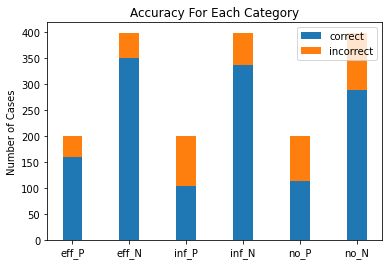

<Figure size 432x288 with 0 Axes>

Effusion Sensitivity     / True Positive Rate:  0.7644230769230769
Infiltration Sensitivity / True Positive Rate:  0.6242424242424243
No Finding Sensitivity   / True Positive Rate:  0.5089285714285714

Effusion Specificity     / True Negative Rate:  0.897172236503856
Infiltration Specificity / True Negative Rate:  0.7777777777777778
No Finding Specificity   / True Negative Rate:  0.7721179624664879


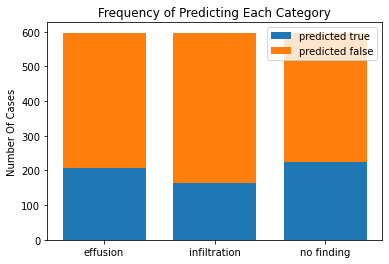

<Figure size 432x288 with 0 Axes>

In [26]:
labels = ['eff_P', 'eff_N', 'inf_P', 'inf_N', 'no_P','no_N']
tru = [tp_eff, tn_eff, tp_inf, tn_inf, tp_no, tn_no]
fal = [fp_eff, fn_eff, fp_inf, fn_inf, fp_no, fn_no]

width = 0.35

fig, ax = plt.subplots()

ax.bar(labels, tru, width, label='correct')
ax.bar(labels, fal, width, bottom=tru,
       label='incorrect')

ax.set_ylabel('Number of Cases')
ax.set_title('Accuracy For Each Category')
ax.legend()

plt.figure()
plt.show()

print('Effusion Sensitivity     / True Positive Rate: ', tp_eff/(tp_eff+fn_eff))
print('Infiltration Sensitivity / True Positive Rate: ', tp_inf/(tp_inf+fn_inf))
print('No Finding Sensitivity   / True Positive Rate: ', tp_no/(tp_no+fn_no))
print()
print('Effusion Specificity     / True Negative Rate: ', tn_eff/(tn_eff+fp_eff))
print('Infiltration Specificity / True Negative Rate: ', tn_inf/(tn_inf+fp_inf))
print('No Finding Specificity   / True Negative Rate: ', tn_no/(tn_no+fp_no))

labels = ['effusion', 'infiltration', 'no finding']
tru = [tp_eff+fn_eff, tp_inf+fn_inf, tp_no+fn_no]
fal = [fp_eff+tn_eff, fp_inf+tn_inf, fp_no+tn_no]

width = 0.75

fig, ax = plt.subplots()

ax.bar(labels, tru, width, label='predicted true')
ax.bar(labels, fal, width, bottom=tru,
       label='predicted false')

ax.set_ylabel('Number Of Cases')
ax.set_title('Frequency of Predicting Each Category')
ax.legend()

plt.figure()
plt.show()
